## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product.  Based on this analysis I will make a recommendation on whether the company should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Import required libraries.

In [97]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42) # used to assure consistent answers on quizzes  

`1.` 

a. Read in the dataset and take a look at the top few rows here:

In [98]:
df = pd.read_csv('ab_data.csv')

In [99]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [168]:
df.timestamp.max(), df.timestamp.min()  # get a sense of duration of the data set - it this case less than 1 month

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

b. Find the number of rows in the dataset.

In [100]:
# Calculate number of rows in dataframe
df_rows = len(df)   
print(df_rows)

294478


c. The number of unique users in the dataset.

In [101]:
# Calculate number of unique visitors
unique_visitors = len(df.user_id.unique())
print(unique_visitors)

290584


d. The proportion of users converted.

In [102]:
# We will look only at rows with unique user ids
# Propotion of converted users = Total Number of Sales of Unique Visitor / Number of Unique Visitors 
df.query('converted == "1"').user_id.nunique() / unique_visitors

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [103]:
# Create 2 dataframe for 2 combinations that "don't line up" - both of these are not expected
df_bad_t = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]
df_bad_c = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]

In [104]:
# Combine these 2 dataframes into one and calculate the total number of rows that don't line up
df_all_bad = df_bad_t.append(df_bad_c)
len(df_all_bad)

3893

f. Do any of the rows have missing values?

In [105]:
# see if any of the colums have less non-null total then total # of dataframe rows which is 294478 (i.e., len(df)) from previous cell
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Conclusion:** no non-nulls in this dataset

`2.` Remove bad rows that "don't line up" from the data set.

In [106]:
# Copy dataframe
df2 = df

# Remove the rows that don't line up since we are not confident in the quality of the data for these visits
bad_rows_index = df_all_bad.index
df2 = df2.drop(bad_rows_index)

In [107]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [108]:
# Check that # of removed rows = # of "bad" rows which is 3893 from previous cell
len(df)-len(df2)

3893

`3.` Remove duplicte users ID so that we are only working with unique visitors.

a. How many unique **user_id**s are in **df2**?

In [109]:
unique_visitors_df2 = len(df2.user_id.unique())
unique_visitors_df2

290584

In [110]:
# Alternatively display the # of duplicate user_ids
df2.user_id.duplicated().sum()

1

b. Display the dup **user_id**.

In [111]:
# Show the repeated user_id
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [112]:
# Find duplicates under user ids
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [113]:
# Drop duplicated user
df2.drop(labels=1899, axis=0, inplace=True)

In [114]:
# confirm drop of dup user id worked - no rows indicate that there are no more dup user ids
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted


`4.` Calculate conversion probabilities

a. What is the probability of an individual converting regardless of the page they receive?

In [120]:
# this is the same as proportion of converted user but this time we will used the clean df2 less rows that are not in line
# We will look only at rows with unique user ids
# Probability of conversion = Total Number of converstion of Unique Visitor / Number of Unique Visitors
df2.query('converted == "1"').user_id.nunique() / unique_visitors_df2

0.11959708724499628

In [118]:
# just checking the above checks for being unique is not needed since we already de-dup the data set
len(df2.query('converted == "1"')) / len(df2)

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [121]:
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [122]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [123]:
df2['landing_page'].value_counts()[0]/len(df2)

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Part 1 Summary**

Given that the mean convertion rate for the treatment group (.119) is less than the mean converstion rate of the control group (.120) or the overall conversion rate regardless of what page was served (also .120 with rounding), there does not seem to be sufficient evidence to say that the new treatment page leads to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Make a decision just based on all the data provided.  Let's assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.  

**Answer:** The null and alternative hypothesis given the question 1 assumption are as follows:

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$

`2.` Now I will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>


**Answer:** For question 2 the null and alternative hypothesis are as follows:

$$H_0: p_{new} - p_{old} = 0$$

$$H_1: p_{new} - p_{old} \neq 0$$

a. What is the **convert rate** for $p_{new}$ under the null? 

In [171]:
# Create dataframe with all treatment records
treatment_df = df2.query('group == "treatment"')

# Compute convert rate for new page for treatment group
treatment_convert = treatment_df['converted'].mean()

# Display observed treatment convert rate
print('p_new =', treatment_convert)

p_new = 0.11880806551510564


In [172]:
# Calculate the observed probability of conversion for new_page
# double check calculation and set p_new
p_new = df2[df2['landing_page']=='new_page']['converted'].mean()
print('p_new =', p_new)

p_new = 0.11880806551510564


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [174]:
# Create dataframe with all treatment records
control_df = df2.query('group == "control"')

# Compute convert rate for new page for control group
control_convert = control_df['converted'].mean()

# Display observed treatment convert rate
print('p_old =', control_convert)

p_old = 0.1203863045004612


In [175]:
# Calculate the observed probability of conversion for old_page
# double check calculation and set p_old
p_old = df2[df2['landing_page']=='old_page']['converted'].mean()
print('p_old =', p_old)

p_old = 0.1203863045004612


**Answer:** Since **convert rate** for $p_{new}$ is equal to **convert rate** for $p_{old}$ under the null they are both equal to .1196 which is the mean of the observed new and the observed old page conversion rate.

In [176]:
# Compute observed difference in convertion rates
obs_diff =  treatment_convert - control_convert

# Display observed difference in completion rates
print('Observed difference in completion rates:', obs_diff)

Observed difference in completion rates: -0.0015782389853555567


c. What is $n_{new}$?

In [133]:
# Calculate n_new and n_old
n_new, n_old = df2['landing_page'].value_counts()

print("n_new = ", n_new) 

n_new =  145310


d. What is $n_{old}$?

In [135]:
print("n_old = ", n_old) 

n_old =  145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [136]:
new_page_converted = np.random.binomial(n_new,treatment_convert)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [137]:
old_page_converted = np.random.binomial(n_old,control_convert)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [177]:
# sample of 1
pdiff_sim = new_page_converted/n_new - old_page_converted/n_old
print('p_new - p_old =', pdiff_sim)

p_new - p_old = -0.0006834532758184242


**Comment:** It's only a sample of 1 so need to create large sampling distribution for the value to have meaning

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [139]:
# Create sampling distribution for difference in convertion rates
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,treatment_convert)
    old_page_converted = np.random.binomial(n_old, control_convert)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  

In [140]:
# convert to numpy array
p_diffs = np.array(p_diffs)

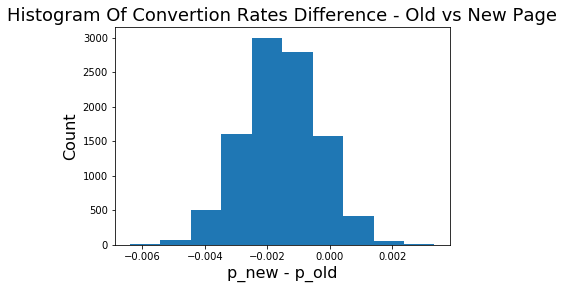

In [178]:
# plot distribution
plt.hist(p_diffs);
plt.title('Histogram Of Convertion Rates Difference - Old vs New Page', fontsize = 18)
plt.xlabel('p_new - p_old', fontsize = 16)
plt.ylabel('Count', fontsize = 16);

**Comment:** This looks as expected.  Given use of np.random.binomial to generate the samples we would expect a normal distribution.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [142]:
# create distribution under the null hypothesis
size = df2.shape[0]
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

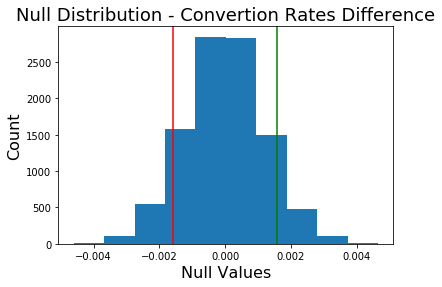

In [180]:
# plot null distribution
# Given the null hypothesis we need to complete a 2 sided analysis for the p-value

plt.hist(null_vals);
plt.title('Null Distribution - Convertion Rates Difference', fontsize = 18)
plt.xlabel('Null Values', fontsize = 16)
plt.ylabel('Count', fontsize = 16);
neg_obs_diff = -1 * obs_diff 

# plot line for acutal observed statistic (-0.0016)
plt.axvline(obs_diff, c='red');

# plot line for negative value observed statistic
plt.axvline(neg_obs_diff, c='green');

In [182]:
# compute p value greater than the actual difference observed (which is the question)
print('p value for proportion > the actual difference observed =',(null_vals > obs_diff).mean())

p value for proportion > the actual difference observed = 0.9062


In [183]:
# compute p value for this test given that it should use a 2 sided analysis for a
# null hypothese where new and old convertion rates are equal.
print('p value using 2 sided test =',(null_vals < obs_diff).mean() + (null_vals > neg_obs_diff).mean())

p value using 2 sided test = 0.1853


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** Given that p value for 2 sided test (0.185) > α (0.05) we have to **fail to reject the null hypothesis**. So based on this we would conclude that there is not enough evidence to say that the new page has a better conversion rate.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [151]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
print('convert_old count:',convert_old)
print('convert_new count:',convert_new)
print('n_old', n_old)
print('n_new', n_new) 

convert_old count: 17489
convert_new count: 17264
n_old 145274
n_new 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [150]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
print('z_score', z_score)
print('p_value', p_value)

z_score 1.31092419842
p_value 0.189883374482


In [184]:
from scipy.stats import norm

# This tells us how significant our z-score is based on above helpful link
print('z-score significance =', norm.cdf(z_score))

z-score significance = 0.905058312759


In [185]:
# 1.959963984540054 # Tells us what our critical value at 95% confidence is based on above helpful link
print('z-score critical value at 95% confidence', norm.ppf(1-(0.05/2)))

z-score critical value at 95% confidence 1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

Since the z-score of 1.31 does not exceeds the critical value of 1.959963984540054, we fail to reject the null hypothesis which is that the difference between the two proportions is equal to zero.  This is consistent with previous analysis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [156]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['group'])['treatment'] # ab_page column has 1 when group is treatment
df2.head(20)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [157]:
import statsmodels.api as sm
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [158]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:55:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [159]:
# exponentiate the ab_page coef to interpret 
np.exp(-.0150)

0.98511193960306265

**Answer** If a visitor is in treatment group (i.e., viewed new_page) they are .99 times more likely to convert relative to a visitor that is in the control (i.e., viewed old_page).  This is very close to one time more likely which is indicating that the treatment page performs very much like the control page supporting the AB test null hypothesis from Part II that the differerence in convertion proportions is zero.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Answer:**

In this analysis the p-value is 0.190 which is slightly larger then the value calculated in Part II (0.185 using 2 sided test approach or 0.1899 using ztest approach).  

One explaination for the differene from Part II is that the null and alternative hypotheses associated with this regression model is different than in Part II. In Part II, the null and alternative hypothesis is about the difference in conversion rates.  For multiple logistic regression the main null hypothesis is that there is no relationship between the X variables and the Y variable (vs. difference in conversion rates).


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**

One disadvantage to adding additional terms is that you could run into issues where these terms have collinearity (linear regession models do not what the explanatory variable to be related).

However, the decision to buy something on an eCommerce site is complex and it makes intuitive sense that other terms should also be considered like: a) the number of visits to the site (i.e., new vs repeat visitors), b) time of day, c) day of week, d) month of the year, e) number of pages views in the session, f) time on site, g) past purchase history (i.e., have they bought something from the site before), and device being used (e.g., PC or mobile).

In summary, if the decision to buy something is viewed as being complex, trying to use just one term is likely to not be the best approach to predicting if a visitor will or will not convert.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

In [160]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [161]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [162]:
# use to get a sense of which country should be the baseline
# selected US since it had the largest count
df_new.country.value_counts() 

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [163]:
### Create the necessary dummy variables
# Exclude US so that we have a full rank matrix, in this case US is my baseline

df_new['intercept'] = 1
df_new[['UK','CA']] = pd.get_dummies(df_new['country'])[['UK','CA']]


In [164]:
### Fit Your Linear Model And Obtain the Results

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Nov 2018   Pseudo R-squ.:               1.521e-05
Time:                        14:05:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [165]:
# resulting value: users with attribute UK or CA are x time more likely to convert relative to US visitors
print('EXP of UK coef', np.exp(.0099))  
print('EXP of CA coef', np.exp(-0.0408))


EXP of UK coef 1.00994916712
EXP of CA coef 0.960021114972


**Summary Of Results:** This model is indicating that for UK visitors there is a 1.01 times increase in conversion relative to US visitors (baseline) holding ab_page constant. With a p value of 0.456 we can conclude this is not statistically significant (i.e. > 0.05 which is a common error rate threshold for p values).

This model is also indicating that for CA visitors there is a 0.96 times increase (affectively a decrease) in conversion relative to US visitors holding ab_page constant. With a p value of 0.129 we can conclude this is not statistically significant (i.e. > 0.05 which is a common error rate threshold for p values).

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.

In [166]:
### Fit Your Linear Model And Obtain the Results

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'CA', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 03 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:07:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

In [167]:
print('EXP of UK coef', np.exp(.0099))  
print('EXP of CA coef', np.exp(-0.0408))  
print('EXP of ab_page coef', np.exp(-0.0149))

EXP of UK coef 1.00994916712
EXP of CA coef 0.960021114972
EXP of ab_page coef 0.985210455723


**Answer:**
No signifanct changes to the coefficients are observed relative to the models where we just looked at ab_page or country as the singular explanatory variable.  The p-values all increase by a very small amount but again the value are such that we can only state that the explanatory variable coefficients are not statistically significant.  


<a id='conclusions'></a>
## Conclusions

### Recommentations
1. Given that the test duration was close to a month with almost 300,000 records I would not recommend running this test for a longer duration.  
2. Based on the analysis in this notebook I would recommend against the implementation of the new page. Three approaches (i.e., calculate probability, AB Test, and logistic regression) where used to review the conversion rate for the old vs new page and none provided statistically significant evidence that the new page performs better than the old page.

One final note is that since we do not know mich about the visitors it is not possible to speculate if change aversion and novelty effects are a possible source of bias that could material impact these recommendations.  